#  Project2 : Ames Housing Project

## Problem Statement

Ames is a town in Iowa with a population of 66,258 in 2019. Ames is in Story County and is one of the best places to live in Iowa. Living in Ames offers residents an urban suburban mix feel and most residents rent their homes. In Ames there are a lot of bars, coffee shops, and parks. Many young professionals live in Ames and residents tend to lean conservative. The public schools in Ames are highly rated. At Ace Real Estate, we are passionate about helping our clients to find a dream house with affordable price. 

As the industry moves to automate the appraisal of house, Ace Real Estate decides to build up data science team to apply machine learning skill to estimate sale price of houses. As a member of the data science team, I will use Ames Housing data which collected from year 2006 to 2010 to build linear regression model to predict the sale price for houses in Ames and provide recommendation for homeowners to  increase their house value. 


## Executive Summary
The Ames housing dataset includes 80 features of nominal, discrete, ordinal and continuous variables for individual residential properties sold in Ames, IA from 2006 to 2010.

During the first step workflow which is data cleaning, missing values were detected and fixed, outlier points are investigated and eliminitated from the dataset. Once data cleaning is done, Exploratory Data Analysis (EDA) is conducted for each feature. Ordinal features are converted to discrete values. For categorical data (nominal), bar plots were created to visualize the mean Sale Price across categories. During EDA for categorical features, special attention was paid to any patterns or clusters in Sale Prices that emerged. I also expore continuous/discrete features with similar groups, like sold/built year, bathroom No and floor SF to create more meaningful new features. 

The linear relationship between Sale Price and all numeric features were examined using heatmap and correlation coefficients. Features with high correlation rate (>=0.4) were filtered out for visualization check. 
Features with continous data were plotted with scatter plot while features with discrete data were plotted with boxplot. 
Heatmap for all filtered-out features were also plotted to check colinear between features. If there was high colinearity between features, the feature with less correlation rate with Sale Price was removed from filtered features list. 

After filtered features list were comfirmed, train dataset was divided into training set (70% of data) and holdout set (30% of data) to prepare for modeling. In this project, 4 models (linear regression/ridge regression/lasso regression/elsticNET regression) were used. 

In the first verification, filtered features list with 27 features from EDA were used for these 4 models. Among these models, elasticNET had best MSE score. However, I observed that with higher Sale Price, the best fit of line did not fit well. In the high sale price side, the line tended to be curly. We decided to add square value (power 2) for some features which had high correction with saleprice to observe whether could improve MSE score and best fit of line in second verification. 

In the second verification, 6 square values (power 2) were added. The result showed much better MSE and slight improvement of best fit line for higher Sale Price. So I decided to try higher power into the features, i.e. add power 3 to verify whether higher power value could further improve the models in the third verification. 

In the third verification, 6 power 3 values were added. MSE scores were improved slightly. By checking lasso regression coeffient, some features' coeffients were zero. This may be due to high colinearity among the feature and its power 2 / power 3. In the fourth verification, features with zero coeffient were dropped. 


In the fourth verification, the MSE score almost had no improvement. However, we can observe the samll gap between train data MSE score and holdout data MSE score. R2 score for train dataset and holdout data set were 91% and 90% respectively. We can say that this model could fit train and holdout data well. 

After we identify our best model, residuals plot was evaluated and Sale Prices in test dataset were predicted. Interpretations and recommendations were made based off of the best-performing model.

## EDA and Data Cleaning Heading

In [229]:
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns


from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
)

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

In [230]:
train_df = pd.read_csv("./datasets/train.csv")

In [231]:
test_df = pd.read_csv("./datasets/test.csv")

### Deal with Null

#### Check null 

In [232]:
# Function to find columns with NA and Count of NA

def NA_columns(df):
    NA_column = {}
    
    for col in df.columns: 
        if df[col].isnull().sum() > 0:
            NA_column[col] = df[col].isnull().sum()
    return NA_column

In [233]:
NA_columns(train_df)

{'Lot Frontage': 330,
 'Alley': 1911,
 'Mas Vnr Type': 22,
 'Mas Vnr Area': 22,
 'Bsmt Qual': 55,
 'Bsmt Cond': 55,
 'Bsmt Exposure': 58,
 'BsmtFin Type 1': 55,
 'BsmtFin SF 1': 1,
 'BsmtFin Type 2': 56,
 'BsmtFin SF 2': 1,
 'Bsmt Unf SF': 1,
 'Total Bsmt SF': 1,
 'Bsmt Full Bath': 2,
 'Bsmt Half Bath': 2,
 'Fireplace Qu': 1000,
 'Garage Type': 113,
 'Garage Yr Blt': 114,
 'Garage Finish': 114,
 'Garage Cars': 1,
 'Garage Area': 1,
 'Garage Qual': 114,
 'Garage Cond': 114,
 'Pool QC': 2042,
 'Fence': 1651,
 'Misc Feature': 1986}

In [234]:
NA_columns(test_df)

{'Lot Frontage': 160,
 'Alley': 821,
 'Mas Vnr Type': 1,
 'Mas Vnr Area': 1,
 'Bsmt Qual': 25,
 'Bsmt Cond': 25,
 'Bsmt Exposure': 25,
 'BsmtFin Type 1': 25,
 'BsmtFin Type 2': 25,
 'Electrical': 1,
 'Fireplace Qu': 422,
 'Garage Type': 44,
 'Garage Yr Blt': 45,
 'Garage Finish': 45,
 'Garage Qual': 45,
 'Garage Cond': 45,
 'Pool QC': 875,
 'Fence': 707,
 'Misc Feature': 838}

In [235]:
# will drop the column with more NA, like Alley, Pool QC, Fence, Misc Feature 
train_df.drop(['Alley', 'Pool QC', 'Fence', 'Misc Feature'], axis = 1, inplace= True )
test_df.drop(['Alley', 'Pool QC', 'Fence', 'Misc Feature'], axis = 1, inplace= True )

#### fill null 

In [236]:
def fill_na(col, fill_data):
    
    if fill_data in ['None', 0, 'NA', 'No']:
        train_df[col] = train_df[col].fillna(fill_data)
        test_df[col] = test_df[col].fillna(fill_data)
    else:
        train_df[col] = train_df[col].fillna(train_df[col].mean())
        test_df[col] = test_df[col].fillna(test_df[col].mean())
    return 

In [237]:
# 1 'Lot Frontage', we will fillna with mean 
fill_na('Lot Frontage', 'mean_data')
fill_na('Mas Vnr Type', 'None')
fill_na('Mas Vnr Area', 0)
fill_na('Bsmt Qual', 'NA')
fill_na('Bsmt Cond', 'NA')
fill_na('Bsmt Exposure', 'No')
fill_na('BsmtFin Type 1', 'NA')
fill_na('BsmtFin SF 1', 0)
fill_na('BsmtFin Type 2', 'NA')
fill_na('BsmtFin SF 2', 0)
fill_na('Bsmt Unf SF', 0)
fill_na('Total Bsmt SF', 0)
fill_na('Bsmt Full Bath', 0)
fill_na('Bsmt Half Bath', 0)
fill_na('Fireplace Qu', 'NA')
fill_na('Garage Type', 'NA')
fill_na('Garage Yr Blt', 0)
fill_na('Garage Finish', 'NA')
fill_na('Garage Cars', 0)
fill_na('Garage Area', 0)
fill_na('Garage Qual', 'NA')
fill_na('Garage Cond', 'NA')
fill_na('Electrical', 'NA')

In [238]:
NA_columns(train_df)

{}

In [239]:
NA_columns(test_df)

{}

### Change ordinal column to numeric

In [240]:
def change_ordinal_data(newcol, col, dic):
    train_df[newcol] = train_df[col].map(dic)
    test_df[newcol] = test_df[col].map(dic)

In [241]:
# 1 'Lot Shape' 
shape_dict = {'Reg': 4,
              'IR1' : 3,
              'IR2' :2, 
              'IR3' : 1            
             }
change_ordinal_data('Ord_lotshape', 'Lot Shape', shape_dict)

In [242]:
# 2. "Utilities"

util_dict = {'AllPub': 4,
              'NoSewr' : 3,
              'NoSeWa' :2, 
              'ELO' : 1           
             }
change_ordinal_data('Ord_utilities', 'Utilities', util_dict)

In [243]:
# 3 "Land Slope"
slope_dict = {'Gtl' : 3,
              'Mod' :2, 
              'Sev' : 1
             
             }
change_ordinal_data('Ord_landslope', 'Land Slope', slope_dict)

In [244]:
#4 'Exter Qual' & 'Exter Cond' & 'Bsmt Qual' & 'KitchenQual' & 'FireplaceQu' & 'Garage Qual' & 
# 'Bsmt Cond' & 'Garage Cond' & 'Heating QC'
qual_dict = {'Ex' : 5,
                   'Gd' : 4, 
                   'TA' : 3,
                   'Fa' : 2,
                   'Po' : 1,
                   'NA' : 0
             }

change_ordinal_data('Ord_exter_qual', 'Exter Qual', qual_dict)
change_ordinal_data('Ord_exter_cond', 'Exter Cond', qual_dict)

change_ordinal_data('Ord_bsmt_qual', 'Bsmt Qual', qual_dict)
change_ordinal_data('Ord_kitchen_qual', 'Kitchen Qual', qual_dict)
change_ordinal_data('Ord_fireplacequ', 'Fireplace Qu', qual_dict)
change_ordinal_data('Ord_garage_qual', 'Garage Qual', qual_dict)

change_ordinal_data('Ord_bsmt_cond', 'Bsmt Cond', qual_dict)
change_ordinal_data('Ord_garage_cond', 'Garage Cond', qual_dict)

change_ordinal_data('Ord_heatingQC', 'Heating QC', qual_dict)

In [245]:
# 5 'Bsmt Exposure'
Bsmt_exo_dict = {'Gd' : 4,
                   'Av' : 3, 
                   'Mn' : 2,
                   'No' : 1,
                   'NA' : 0,
             }

change_ordinal_data('Ord_bsmt_exposure', 'Bsmt Exposure', Bsmt_exo_dict)

In [246]:
# 6 'BsmtFin Type 1' & 'BsmtFin Type 2'

BsmtFin_type_dict = {'GLQ' : 6,
                      'ALQ' : 5, 
                      'BLQ' : 4,
                      'Rec' : 3,
                      'LwQ' : 2,
                      'Unf' : 1,
                      'NA' : 0
             }

change_ordinal_data('Ord_bsmtfintype1', 'BsmtFin Type 1', BsmtFin_type_dict)
change_ordinal_data('Ord_bsmtfintype2', 'BsmtFin Type 2', BsmtFin_type_dict)

In [247]:
# 7 'Electrical'

Electrical_dict = {'SBrkr' : 5,
                      'FuseA' : 4, 
                      'FuseF' : 3,
                      'FuseP' : 2,
                      'Mix' : 1,
                    'NA' : 0
             }

change_ordinal_data('Ord_electrical', 'Electrical', Electrical_dict)

In [248]:
# 8 'Functional'
Functional_dict = {'Typ' : 8,
                   'Min1' : 7, 
                   'Min2' : 6,
                   'Mod' : 5,
                   'Maj1' : 4,
                   'Maj2' : 3,
                   'Sev' : 2,
                   'Sal' : 1
             }

change_ordinal_data('Ord_functional', 'Functional', Functional_dict)

In [249]:
# 9 'Garage Finish'

Garage_Finish_dict = {'Fin': 3,
                   'RFn' : 2, 
                   'Unf' : 1,
                   'NA' : 0,
             }

change_ordinal_data('Ord_garage_finish', 'Garage Finish', Garage_Finish_dict)

In [250]:
# 10 'Paved Drive'
Paved_Drive_dict = {'Y' : 3,
                   'P' : 2, 
                   'N' : 1,
             }

change_ordinal_data('Ord_paved_drive', 'Paved Drive', Paved_Drive_dict)

### Drop unnecessary columns

In [251]:
# Drop the columns of ordinal data for which we convert to numeric data that we have done in 1.1.2. 

train_df.drop(['Lot Shape', 
               'Utilities', 
               'Land Slope', 
               'Exter Qual', 
               'Bsmt Qual', 
               'Kitchen Qual', 
               'Fireplace Qu', 
               'Garage Qual', 
               'Bsmt Cond', 
               'Garage Cond', 
               'Bsmt Exposure', 
               'BsmtFin Type 1', 
               'BsmtFin Type 2', 
               'Heating QC', 
               'Electrical', 
               'Functional', 
               'Garage Finish', 
               'Paved Drive'], 
              axis = 1, inplace = True)

In [252]:
# Drop the columns of ordinal data for which we convert to numeric data that we have done in 1.1.2. 
test_df.drop(['Lot Shape', 
              'Utilities', 
              'Land Slope', 
              'Exter Qual', 
              'Bsmt Qual', 
              'Kitchen Qual', 
              'Fireplace Qu', 
              'Garage Qual', 
              'Bsmt Cond', 
              'Garage Cond', 
              'Bsmt Exposure', 
              'BsmtFin Type 1', 
              'BsmtFin Type 2', 
              'Heating QC', 
              'Electrical', 
              'Functional', 
              'Garage Finish', 
              'Paved Drive'],
             axis = 1, inplace = True)

### delete outliers

From the data dictionary, they suggest to drop the outliers with Gr Liv Area > 4000 and unusual low price for lot area > 100000. 

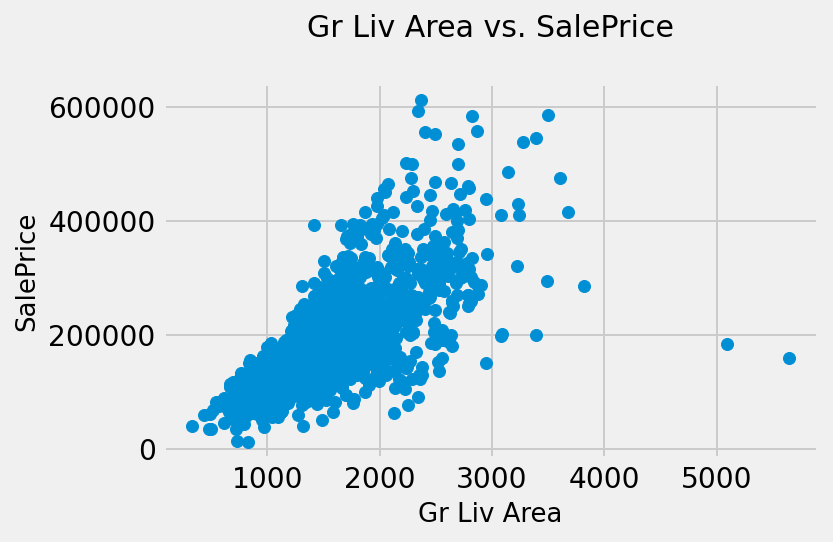

In [253]:
plt.scatter(train_df['Gr Liv Area'],  train_df['SalePrice'])
plt.title('Gr Liv Area vs. SalePrice\n', fontdict = {'fontsize':15})
plt.xlabel('Gr Liv Area', fontdict = {'fontsize':13})
plt.ylabel('SalePrice', fontdict = {'fontsize':13})
plt.tight_layout();

In [254]:
# remove outlier for train_df['Gr Liv Area'] > 4000

train_df.loc[train_df['Gr Liv Area'] > 4000]


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Land Contour,Lot Config,Neighborhood,...,Ord_bsmt_cond,Ord_garage_cond,Ord_heatingQC,Ord_bsmt_exposure,Ord_bsmtfintype1,Ord_bsmtfintype2,Ord_electrical,Ord_functional,Ord_garage_finish,Ord_paved_drive
960,1499,908154235,60,RL,313.0,63887,Pave,Bnk,Corner,Edwards,...,3,3,5,4,6,1,5,8,3,3
1885,2181,908154195,20,RL,128.0,39290,Pave,Bnk,Inside,Edwards,...,3,3,5,4,6,1,5,8,3,3


In [255]:
train_df.drop(train_df.loc[train_df['Gr Liv Area'] > 4000].index, inplace=True)

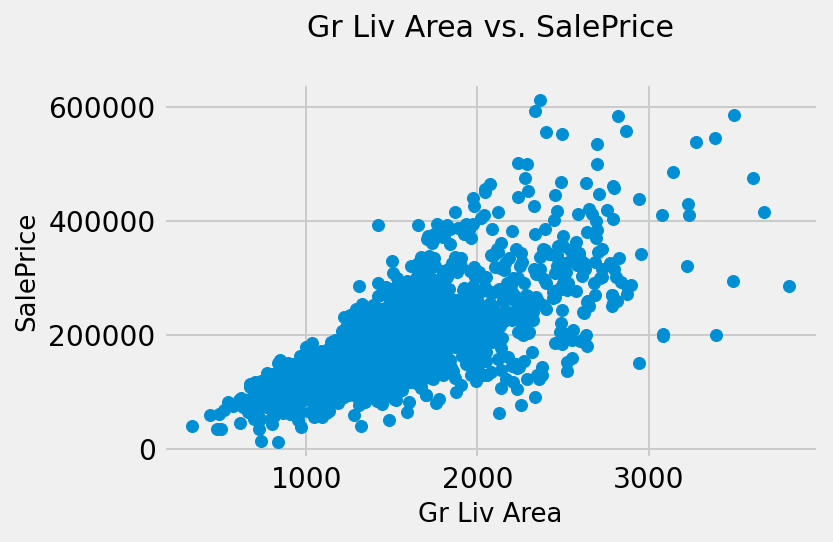

In [256]:
plt.scatter(train_df['Gr Liv Area'],  train_df['SalePrice'])
plt.title('Gr Liv Area vs. SalePrice\n', fontdict = {'fontsize':15})
plt.xlabel('Gr Liv Area', fontdict = {'fontsize':13})
plt.ylabel('SalePrice', fontdict = {'fontsize':13})
plt.tight_layout();

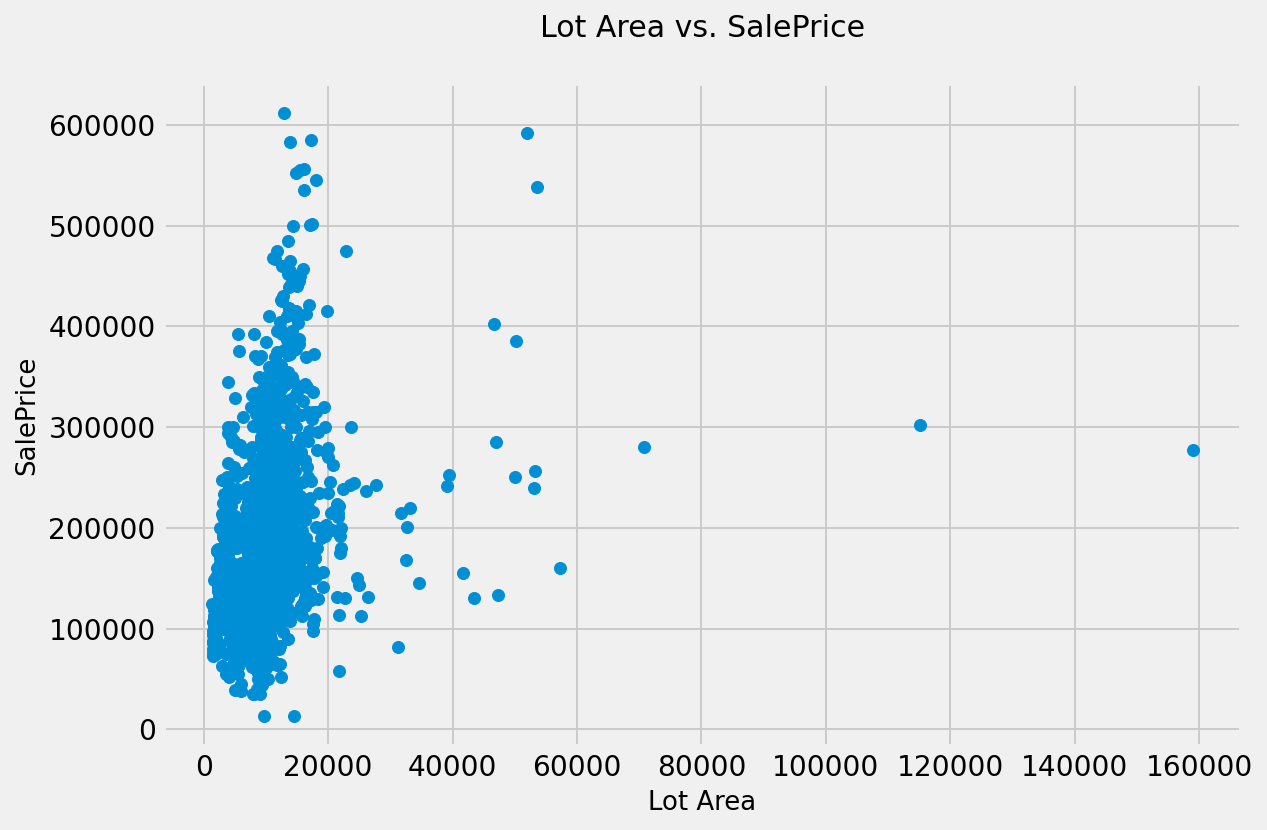

In [257]:
plt.figure(figsize=(9,6))
plt.scatter(train_df['Lot Area'],  train_df['SalePrice'])
plt.title('Lot Area vs. SalePrice\n', fontdict = {'fontsize':15})
plt.xlabel('Lot Area', fontdict = {'fontsize':13})
plt.ylabel('SalePrice', fontdict = {'fontsize':13})
plt.tight_layout();

In [258]:
train_df.loc[train_df['Lot Area'] > 100000]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Land Contour,Lot Config,Neighborhood,...,Ord_bsmt_cond,Ord_garage_cond,Ord_heatingQC,Ord_bsmt_exposure,Ord_bsmtfintype1,Ord_bsmtfintype2,Ord_electrical,Ord_functional,Ord_garage_finish,Ord_paved_drive
471,2116,906426060,50,RL,69.0552,159000,Pave,Low,CulDSac,ClearCr,...,3,3,4,4,3,1,5,8,3,3
694,2072,905301050,20,RL,69.0552,115149,Pave,Low,CulDSac,ClearCr,...,3,3,3,4,6,1,5,8,1,3


In [259]:
train_df.drop(train_df.loc[train_df['Lot Area'] > 100000].index, inplace = True)

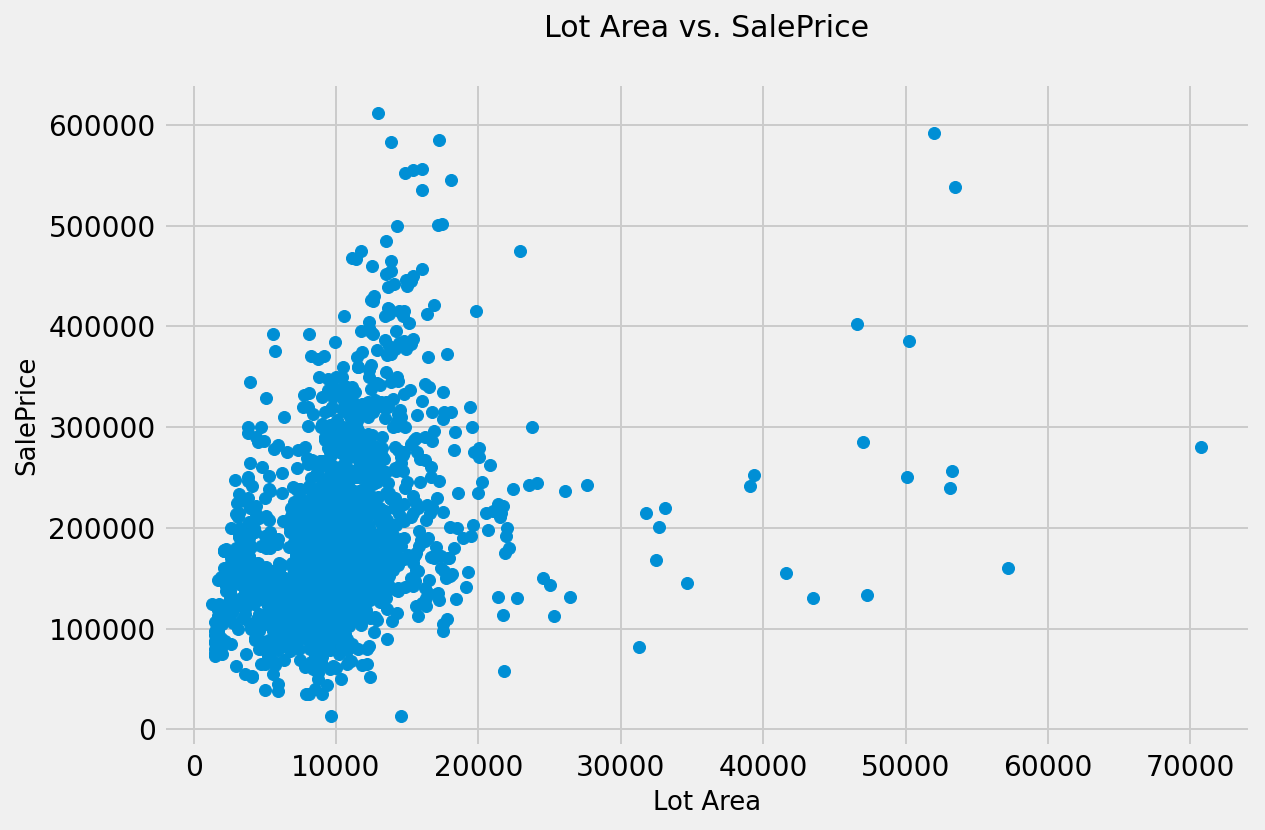

In [260]:
plt.figure(figsize=(9,6))
plt.scatter(train_df['Lot Area'],  train_df['SalePrice'])
plt.title('Lot Area vs. SalePrice\n', fontdict = {'fontsize':15})
plt.xlabel('Lot Area', fontdict = {'fontsize':13})
plt.ylabel('SalePrice', fontdict = {'fontsize':13})
plt.tight_layout();

### create house age, garage age and remod period

In [261]:
train_df['house_age'] = train_df['Yr Sold'] - train_df['Year Built']
test_df['house_age'] = test_df['Yr Sold'] - test_df['Year Built']

In [262]:
train_df['remod_period'] = train_df['Yr Sold'] - train_df['Year Remod/Add']
test_df['remod_period'] = test_df['Yr Sold'] - test_df['Year Remod/Add']

In [263]:
train_df['garage_age'] = train_df['Yr Sold'] - train_df['Garage Yr Blt']
test_df['garage_age'] = test_df['Yr Sold'] - test_df['Garage Yr Blt']

In [264]:
train_df['remod_period'] = train_df['remod_period'].map(lambda x: 0 if x < 0 else x)
test_df['remod_period'] = test_df['remod_period'].map(lambda x: 0 if x < 0 else x)

In [265]:
train_df['garage_age'] = train_df['garage_age'].map(lambda x: 0 if (x < 0 or x > 2000) else x)
test_df['garage_age'] = test_df['garage_age'].map(lambda x: 0 if (x < 0 or x > 2000) else x)

In [266]:
# drop 'Yr Sold', 'Year Built', 'Garage Yr Blt', 'Year Remod/Add' columns
train_df.drop(['Yr Sold', 'Year Built', 'Garage Yr Blt', 'Year Remod/Add'], axis = 1, inplace = True)
test_df.drop(['Yr Sold', 'Year Built', 'Garage Yr Blt', 'Year Remod/Add'], axis = 1, inplace = True)

### Create combine features for similar group of existing feathers

In [267]:
train_df['AllFlrSF'] = train_df['1st Flr SF'] + train_df['2nd Flr SF']
test_df['AllFlrSF'] = test_df['1st Flr SF'] + test_df['2nd Flr SF']

In [268]:
train_df['AllPorchSF'] = train_df['Open Porch SF'] + train_df['Enclosed Porch'] + train_df['3Ssn Porch'] + train_df['Screen Porch']
test_df['AllPorchSF'] = test_df['Open Porch SF'] + test_df['Enclosed Porch'] + test_df['3Ssn Porch'] + test_df['Screen Porch']

In [269]:
train_df['AllSF'] = train_df['Gr Liv Area'] + train_df['Total Bsmt SF']
test_df['AllSF'] = test_df['Gr Liv Area'] + test_df['Total Bsmt SF']

In [270]:
train_df['TotalBath'] = train_df['Bsmt Full Bath'] + train_df['Bsmt Half Bath']*0.5 + train_df['Full Bath'] + train_df['Half Bath']*0.5
test_df['TotalBath'] = test_df['Bsmt Full Bath'] + test_df['Bsmt Half Bath']*0.5 + test_df['Full Bath'] + test_df['Half Bath']*0.5

### change data type for easy data visualization

In [271]:
change_int_list = ['Bsmt Full Bath','Bsmt Half Bath', 'Garage Cars']
train_df[change_int_list] = train_df[change_int_list].astype('int64')

In [272]:
change_float_list = ['Lot Area', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'AllFlrSF', 'AllPorchSF', 'house_age', 'remod_period']
train_df[change_float_list] = train_df[change_float_list].astype('float64')

### Deal with categorical data

In this part, we will exclude out some categorical columns for further aanalysis. In these exlcuded categorical columns, only one category is the majority. 

In [112]:
# train_df categorical features list 
train_cat_list = [item for item in train_df.columns.tolist() if train_df.dtypes[item] == object]

In [113]:
# filter out features which has one category's percentage > 0.8
def filetred_list(list):
    filtered_list = []
    
    for key, item in enumerate(list):
        size = train_df[item].value_counts().size
        series = train_df[item].value_counts(normalize = True)

        for index in range(size):
            if series[index] > 0.8:
                filtered_list.append(item)
    return filtered_list

In [114]:
exclude_cat_list = filetred_list(train_cat_list)

In [115]:
exclude_cat_list

['Street',
 'Land Contour',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'Roof Matl',
 'Exter Cond',
 'Heating',
 'Central Air',
 'Sale Type']

In [116]:
# This the categorical columns that we will do further analysis. 
train_catlist_refine = [x for x in train_cat_list if x not in exclude_cat_list]

####  Bar plot for features with many categories

In [117]:
# define barplot subplot function
def bar_subplot(Dataframe, xlist, y):
    
    nrows = int(np.ceil(len(xlist)/2))
    ncols = 2
    fig, axes = plt.subplots(nrows=nrows, ncols = ncols) 
    fig.set_figheight(nrows*15)
    fig.set_figwidth(15)

    
    for row in range(nrows):
        for col in range(ncols):
            index = row*2+col
            if index >= len(xlist):
                return
            ax=axes[row,col]
            xlabel = xlist[index]
            ax.set_title(xlabel + " / Price")
            sns.barplot(x = xlabel, y = y, data = Dataframe,ax=ax)

            ax.set_xlabel(xlabel)
            ax.set_ylabel(y)
            ax.set_xticklabels(Dataframe[xlabel].unique().tolist(), Rotation= 75)

<ipython-input-117-fecb7576ea03>:23: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels(Dataframe[xlabel].unique().tolist(), Rotation= 75)
<ipython-input-117-fecb7576ea03>:23: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels(Dataframe[xlabel].unique().tolist(), Rotation= 75)
<ipython-input-117-fecb7576ea03>:23: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels(Dataframe[xlabel].unique().tolist(), Rotation= 75)
<ipython-input-117-fecb7576ea03>:23: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels(Dataframe[xlabel].unique().tolist(), Rotation= 75)
<ipython-input-117-fecb7576e

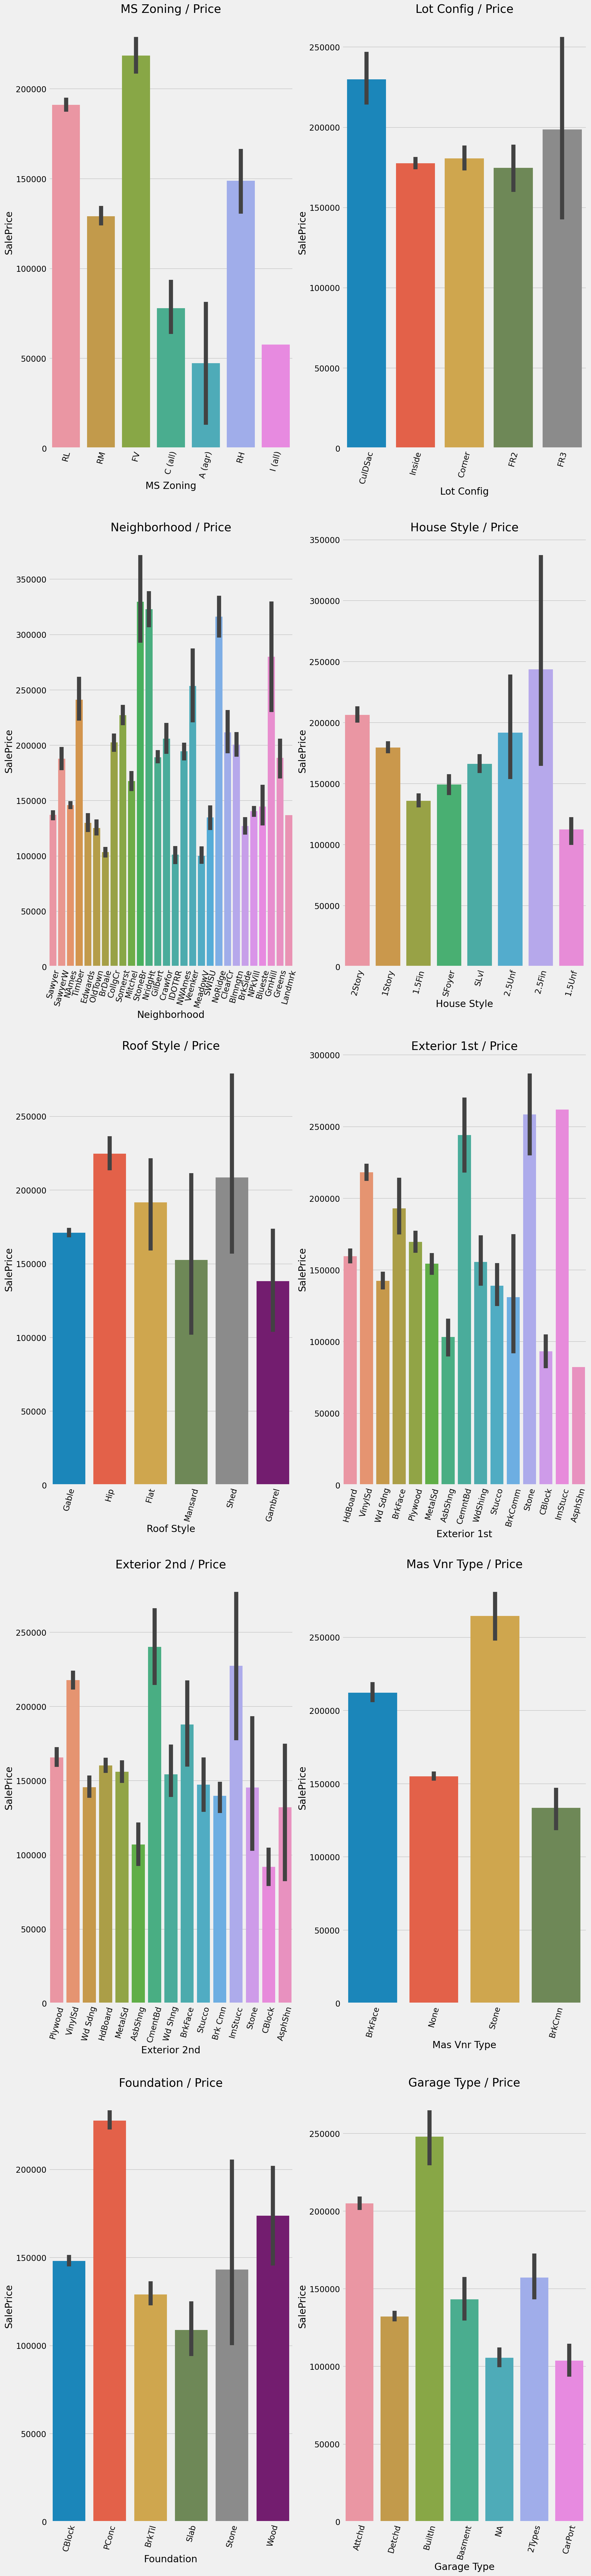

In [118]:
xlist = train_catlist_refine
y = 'SalePrice'
bar_subplot(train_df, xlist, y)

#### One-hot encode categorical variables

From previous barplot for categorical features, we can observe that the following factors can affect SalePrice more. (for saleprice > 200,000). We will do one-hot encode for these factors.

1. MS Zoning - FV
3. Lot Config - CulDSac
4. neighbors - > need to do seperately
5. House Style - 2Story/2.5Fin
6. Root Style - Hip/Shed
7. Exterior 1st --> VinylSd/CemntBd/Stone/lmStucc
8. Exterior 2nd  -- > VinylSd/CemntBd/lmStucc
9. Mas vnr Type - Stone/BrkFace
10. Foundation - PConc
11. garage type - Builtin/Attchd

In [119]:
def one_hot_encode(grouplist, colname, newcolname):
    train_df[newcolname] = train_df[colname].map(lambda name: 1 if name in grouplist else 0)
    test_df[newcolname] = test_df[colname].map(lambda name: 1 if name in grouplist else 0)
    return

In [120]:
#1 'Neighborhood
group1 = ['StoneBr', 'NridgHt', 'Veenker', 'NoRidge', 'GrnHill']
group2 = ['SawyerW', 'CollgCr', 'Somerst', 'Gilbert', 'Crawfor', 'NAmes', 'ClearCr', 'Blmngtn', 'Greens']

one_hot_encode(group1, 'Neighborhood', 'Cat_neighborhoods_1')
one_hot_encode(group2, 'Neighborhood', 'Cat_neighborhoods_2')

In [121]:
# 2. MS Zoning - FV
group_ms = ['FV']
one_hot_encode(group_ms, 'MS Zoning', 'Cat_mszone')

In [122]:
#3 Lot Config - CulDSac
group_lc = ['CulDSac']
one_hot_encode(group_lc, 'Lot Config', 'Cat_lotconfig')

In [123]:
# 4 House Style - 2Story/2.5Fin
group_hs = ['2Story', '2.5Fin']
one_hot_encode(group_hs, 'House Style', 'Cat_housestyle')

In [124]:
# 5 Root Style - Hip/Shed
group_rs = ['Hip', 'Shed']
one_hot_encode(group_rs, 'Roof Style', 'Cat_roofstyle')

In [125]:
# 6 Exterior 1st --> VinylSd/CemntBd/Stone/lmStucc
group_e1 = ['VinylSd', 'CmentBd', 'Stone', 'ImStucc']
one_hot_encode(group_e1, 'Exterior 1st', 'Cat_exterior1')

In [126]:
#7. Exterior 2nd  -- > VinylSd/CemntBd/lmStucc
group_e2 = ['VinylSd', 'CmentBd', 'ImStucc']
one_hot_encode(group_e2, 'Exterior 2nd', 'Cat_exterior2')

In [127]:
# 8. Mas vnr Type - Stone/BrkFace
group_mvt = ['Stone', 'BrkFace']
one_hot_encode(group_mvt, 'Mas Vnr Type', 'Cat_masvnrtype')

In [128]:
# 9. Foundation - PConc
group_fn = ['PConc']
one_hot_encode(group_fn, 'Foundation', 'Cat_foundation')

In [129]:
#10. garage type - Builtin/Attchd
group_gt = ['BuiltIn', 'Attchd']
one_hot_encode(group_gt, 'Garage Type', 'Cat_garagetype')

In [130]:
# We will use this categorical data for further analysis. 
cat_features_list = ['Cat_neighborhoods_1', 'Cat_neighborhoods_2', 'Cat_mszone', 'Cat_lotconfig', 'Cat_housestyle', 'Cat_roofstyle', 'Cat_exterior1', 'Cat_exterior2', 'Cat_masvnrtype', 'Cat_foundation','Cat_garagetype' ]

### output clean dataset

In [131]:
train_df.to_csv("./datasets/train_clean.csv", index=False)

In [132]:
test_df.to_csv("./datasets/test_clean.csv", index=False)